### refs usadas:
- https://www.researchgate.net/publication/324929106_Dynamic_Models_of_a_Home_Refrigerator
- http://www.ingaero.uniroma1.it/attachments/2176_Cap_3%20Thermal-electrical%20analogy.pdf
- https://www.engineeringtoolbox.com/heat-work-energy-d_292.html
- https://economizandoenergia.wordpress.com/2011/12/11/hackeando-a-geladeira/

### refs não usadas, mas interessantes:
- https://www.researchgate.net/publication/269930557_Temperature_control_in_a_cavity_of_refrigeration_using_PI_controller_and_predictive_control
- http://greenteapress.com/modsimpy/ModSimPy3.pdf


#### Breve revisão de calor no ponto de vista energético:
- Para aquecer um corpo de massa $m$ de calor específico $c_p$ em diferença de temperatura $dT$ é necessário o calor $Q$ (em _Joules_), de modo que:
$$ Q = c_p\,m\,dT $$
- A potência (em _Watts_) necessária para aquecer o mesmo corpo em um intervalo de tempo $t$ é:
$$ q = Q / t $$

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

def generate_freezer_unit(sensor_id: int, verbose=False):
    """ consumo médio de um congelador:
    ref:  http://www.procelinfo.com.br/services/DocumentManagement/FileDownload.EZTSvc.asp?DocumentID={8898769E-E9B6-4AB9-A509-CCAFE715310F}&ServiceInstUID={46764F02-4164-4748-9A41-C8E7309F80E1}
    modelo: RCFB32
    compartimento: 385 Litros
    consumo: 35.9 kwh/mês

    ref:  https://www.mideastore.com.br/media/productattach/m/a/manual_do_usu_rio_3.pdf
    Corrente nominal de operação em 220V: 1.6A
    
    # Parece ok, resultados proximos de: https://economizandoenergia.wordpress.com/tag/freezer/
    """
    E_monthly = 35.9e3 * (0.95 + 0.05 * np.random.rand()) # adicionando uma variação para as unidades
    E_anualy = E_monthly * 12
    hours_per_year = 8760
    E_hourly = E_anualy / hours_per_year
    E_daily = E_hourly * 24
    E_minutely = E_hourly / 60
    E_secondly = E_minutely / 60
    # print(E_anualy, E_monthly, E_daily, E_hourly, E_minutely, E_secondly)

    # Estimativas para fechar com os dados de catálogo:
    I_nominal = 1.6 * (0.8 + 0.2 * np.random.rand()) # adicionando uma variação para as unidades
    P_nominal = 220 * I_nominal
    P_nominal_avg = 250
    on_to_off_factor = P_nominal_avg / P_nominal
    P_on = 220 * I_nominal * on_to_off_factor 
    P_off = 220 * I_nominal * (1 - on_to_off_factor)
    if verbose:
        print(f"P nominal = {P_nominal} W")
        print(f"Pon = {P_on} W")
        print(f"Poff = {P_off} W")
        print(f"Check: {P_nominal == P_on + P_off}")

    t_daily = 24.0
    P_daily = E_daily / t_daily
    t_on = t_daily * (P_daily - P_off) / (P_off - P_on)
    t_off = t_daily - t_on
    duty_cycle = t_on / t_daily
    if verbose:
        print(f"daily total: P = {P_daily} W, t = {t_daily} h")
        print(f"daily on: P = {P_on} W, t = {t_on} h")
        print(f"daily off: P = {P_off} W, t = {t_off} h")
        print(f"duty cycle: {duty_cycle * 100} %")
        print(f"Check: {t_daily == t_on + t_off}")
        
    return {
        'sensor_id': sensor_id,
        'model': 'RCFB32',
        'volume': 385,
        'E_monthly': E_monthly,
        'E_anualy': E_anualy,
        'E_hourly': E_hourly,
        'E_daily': E_daily,
        'E_minutely': E_minutely,
        'E_secondly': E_secondly,
        'I_nominal': I_nominal,
        'P_nominal': P_nominal,
        'P_nominal_avg': P_nominal_avg,
        'on_to_off_factor': on_to_off_factor,
        'P_on': P_on,
        'P_off': P_off,
        't_daily': t_daily,
        'P_daily': P_daily,
        't_on': t_on,
        't_off': t_off,
        'duty_cycle': duty_cycle,
    }

print("EXAMPLE:\n")
example = generate_freezer_unit(0,verbose=True)
display(example)

EXAMPLE:

P nominal = 321.83822420075217 W
Pon = 250.00000000000003 W
Poff = 71.83822420075215 W
Check: True
daily total: P = 48.4425021209265 W, t = 24.0 h
daily on: P = 250.00000000000003 W, t = 3.1516150273923462 h
daily off: P = 71.83822420075215 W, t = 20.848384972607654 h
duty cycle: 13.131729280801444 %
Check: True


{'sensor_id': 0,
 'model': 'RCFB32',
 'volume': 385,
 'E_monthly': 35363.02654827635,
 'E_anualy': 424356.3185793162,
 'E_hourly': 48.442502120926505,
 'E_daily': 1162.620050902236,
 'E_minutely': 0.8073750353487751,
 'E_secondly': 0.013456250589146252,
 'I_nominal': 1.462901019094328,
 'P_nominal': 321.83822420075217,
 'P_nominal_avg': 250,
 'on_to_off_factor': 0.7767877809444356,
 'P_on': 250.00000000000003,
 'P_off': 71.83822420075215,
 't_daily': 24.0,
 'P_daily': 48.4425021209265,
 't_on': 3.1516150273923462,
 't_off': 20.848384972607654,
 'duty_cycle': 0.13131729280801444}

# Abrindo banco de dados de temperaturas de florianópolis

,ta
timestamp,
2019-01-01 01:00:00,26.9
2019-01-01 02:00:00,26.6
2019-01-01 03:00:00,26.4
2019-01-01 04:00:00,26.5
2019-01-01 05:00:00,26.5
...,...
2019-12-31 19:00:00,29.3
2019-12-31 20:00:00,28.0
2019-12-31 21:00:00,27.2


,ta
count,8751.000000
mean,21.815987
std,4.298974
min,5.100000
25%,19.200000
50%,21.900000
75%,24.600000
max,39.300000


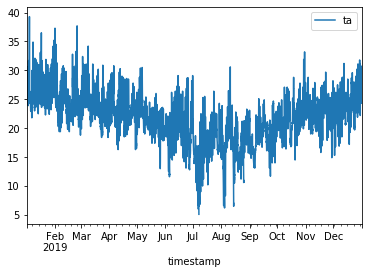

In [2]:
ta_df = pd.read_csv(
    'data/ambient_temperature_hourly.csv',
    header=10,
    date_parser=pd.to_datetime,
    names=['timestamp', 'ta'],
    index_col='timestamp',
)
display(ta_df)
display(ta_df.describe())
ta_df.plot()

Função para plotar multiplos gráficos com eixos diferentes

In [3]:
def plot_multi(data, cols=None, spacing=.1, **kwargs):
    """ https://stackoverflow.com/questions/11640243/pandas-plot-multiple-y-axes """
    from pandas import plotting

    # Get default color style from pandas - can be changed to any other color list
    if cols is None: cols = data.columns
    if len(cols) == 0: return
#     colors = plotting._style._get_standard_colors(num_colors=len(cols))
    colors = getattr(getattr(plotting, '_matplotlib').style, '_get_standard_colors')(num_colors=len(cols))

    # First axis
    ax = data.loc[:, cols[0]].plot(label=cols[0], color=colors[0], **kwargs)
    ax.set_ylabel(ylabel=cols[0])
    lines, labels = ax.get_legend_handles_labels()

    for n in range(1, len(cols)):
        # Multiple y-axes
        ax_new = ax.twinx()
        ax_new.spines['right'].set_position(('axes', 1 + spacing * (n - 1)))
        data.loc[:, cols[n]].plot(ax=ax_new, label=cols[n], color=colors[n % len(colors)], **kwargs)
        ax_new.set_ylabel(ylabel=cols[n])

        # Proper legend position
        line, label = ax_new.get_legend_handles_labels()
        lines += line
        labels += label

    ax.legend(lines, labels, loc=0)
    return ax

# from random import randrange

# data = pd.DataFrame(dict(
#     s1=[randrange(-1000, 1000) for _ in range(100)],
#     s2=[randrange(-100, 100) for _ in range(100)],
#     s3=[randrange(-10, 10) for _ in range(100)],
# ))

# plot_multi(data.cumsum(), figsize=(10, 5))

# Gerando os dados do sensor

,ambiente_temperature,energy,active_power,voltage,current,internal_temperature,cost
count,8751.000000,8751.000000,8751.000000,8759.000000,8751.000000,8759.000000,8751.000000
mean,21.815987,0.038893,38.892679,220.059438,0.176750,5.408213,111.378335
std,4.298974,0.009487,9.486814,1.454744,0.043144,1.629538,58.989212
min,5.100000,0.009238,9.238349,217.510500,0.041574,1.319389,0.030234
25%,19.200000,0.032293,32.292859,218.790658,0.146667,4.106144,62.915702
50%,21.900000,0.038224,38.224187,220.079577,0.173739,5.640170,115.609677
75%,24.600000,0.045007,45.006809,221.330915,0.204505,6.549419,158.971726
max,39.300000,0.084830,84.830124,222.590645,0.385813,8.794810,215.267017


,ambiente_temperature,energy,active_power,voltage,current,internal_temperature,cost,status
timestamp,,,,,,,,
1577840400,26.9,0.047802,47.802480,220.210301,0.217076,8.431166,0.030234,ON
1577844000,26.6,0.053702,53.702106,218.169270,0.246149,8.419315,0.064200,ON
1577847600,26.4,0.055003,55.003446,218.794882,0.251393,7.665356,0.098989,ON
1577851200,26.5,0.038970,38.969805,219.629383,0.177434,8.404809,0.123637,ON
1577854800,26.5,0.041204,41.203620,222.493791,0.185190,8.509338,0.149698,ON


,ambiente_temperature,energy,active_power,voltage,current,internal_temperature,cost,status
timestamp,,,,,,,,
1609441200,29.3,0.044770,44.770271,219.120039,0.204318,7.365939,215.154000,ON
1609444800,28.0,0.038865,38.865266,221.904923,0.175144,8.242717,215.178582,ON
1609448400,27.2,0.057493,57.492852,221.581542,0.259466,7.573237,215.214945,ON
1609452000,26.2,0.038707,38.707441,219.205628,0.176581,7.660086,215.239427,ON
1609455600,26.3,0.043622,43.621557,221.477809,0.196957,7.526564,215.267017,ON


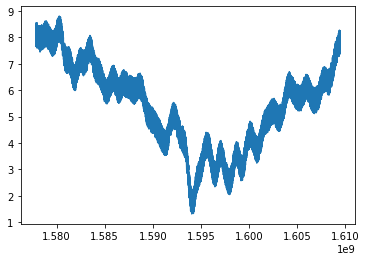

Done: the data for the sensor id 0 was saved to: data/db/0_sensor_0_db.csv


,ambiente_temperature,energy,active_power,voltage,current,internal_temperature,cost
count,8751.000000,8751.000000,8751.000000,8759.000000,8751.000000,8759.000000,8751.000000
mean,21.815987,0.035385,35.385321,220.059091,0.160811,5.609004,111.255898
std,4.298974,0.014336,14.336387,1.454577,0.065171,1.973986,58.008067
min,5.100000,0.000000,0.000000,217.508261,0.000000,1.214723,0.027891
25%,19.200000,0.029977,29.977294,218.794417,0.135990,4.093435,63.232892
50%,21.900000,0.036972,36.972177,220.076135,0.168182,5.674851,116.534166
75%,24.600000,0.044192,44.192425,221.327720,0.200692,6.763958,159.897298
max,39.300000,0.079352,79.352458,222.595428,0.360537,13.213060,195.854147


,ambiente_temperature,energy,active_power,voltage,current,internal_temperature,cost,status
timestamp,,,,,,,,
1577840400,26.9,0.044097,44.097385,220.283483,0.200185,7.834893,0.027891,ON
1577844000,26.6,0.049656,49.655507,218.192994,0.227576,7.819315,0.059298,ON
1577847600,26.4,0.047597,47.596730,218.796117,0.217539,8.525586,0.089402,ON
1577851200,26.5,0.053185,53.184524,219.640967,0.242143,8.456591,0.123040,ON
1577854800,26.5,0.051289,51.289380,222.501512,0.230512,7.660130,0.155480,ON


,ambiente_temperature,energy,active_power,voltage,current,internal_temperature,cost,status
timestamp,,,,,,,,
1609441200,29.3,0.0,0.0,219.112291,0.0,12.650286,195.854147,OFF
1609444800,28.0,0.0,0.0,221.855114,0.0,12.860994,195.854147,OFF
1609448400,27.2,0.0,0.0,221.610003,0.0,13.210257,195.854147,OFF
1609452000,26.2,0.0,0.0,219.183540,0.0,12.551421,195.854147,OFF
1609455600,26.3,0.0,0.0,221.441304,0.0,12.904723,195.854147,OFF


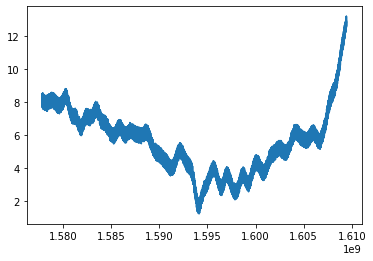

Done: the data for the sensor id 1 was saved to: data/db/0_sensor_1_db.csv


In [4]:
voltage = 220 + (np.random.rand(len(ta_df)) * 5 - 2.5)
basic_energy_tariff = 0.50599 * (1 + 0.25)  # Tarifa residencial B da celesc + aliquota: 12% se menor que 150kWh, 25% se maior.

def generate_sensor_dataframe(df, sensor: dict, verbose=False, plot=False):
    # Change from 2019 to 2020
    df.index += pd.DateOffset(years=1)
    
    df['E'] = (0.6 + 0.4*np.random.rand(len(df))) * sensor['E_hourly'] * df['ta'] / df['ta'].mean() / 1000 # kwh    
    df['P'] = 1000 * df['E'] / 1 # watts
    df['V'] = voltage + 0.1 * np.random.rand(len(df))
    df['I'] = df['P'] / df['V']
    df['ti'] = 4 + np.random.rand(len(df)) + 0.5*df['ta'].rolling(500, win_type='blackman', center=True, min_periods=1).mean() -10
    
    if sensor['sensor_id'] == 1:
        time_now = datetime.now().replace(microsecond=0, second=0, minute=0)
        df.loc[time_now:, ['E', 'P', 'I']] = 0
        df.loc[time_now:, 'ti'] += 0.001 * df.loc[time_now:, 'ti'].cumsum()
        
    df['cost'] = df['E'].cumsum() * basic_energy_tariff
    
    df['status'] = "OFF"
    df.loc[df['I'] > 0, 'status'] = "ON"

    # Convert to epoch in ms
    df.index = (df.index - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')

    df = df.rename(columns={
        "ta": "ambiente_temperature",
        "ti": "internal_temperature",
        "V": "voltage",
        "I": "current",
        "P": "active_power",
        "E": "energy",
        "cost": "cost",
        "status": "status",
    })
    if verbose:
        display(df.describe())
        display(df.head())
        display(df.tail())
    if plot:
        plt.Figure(figsize=(20, 10))
#         plt.plot(df.rolling(1, win_type='blackman', center=True, min_periods=1).mean())
        plt.plot(df['internal_temperature'])
#         plot_multi(df.rolling(25, win_type='blackman', center=True, min_periods=1).mean())
        plt.show()

    output_filename = f"data/db/0_sensor_{int(sensor['sensor_id'])}_db.csv"
    df.to_csv(output_filename, float_format='%.4f')
    print(f"Done: the data for the sensor id {sensor['sensor_id']} was saved to: {output_filename}")
    del df


for sensor_id in [0,1]:
    sensor = generate_freezer_unit(sensor_id)
    generate_sensor_dataframe(ta_df.copy(), sensor, verbose=True, plot=True)